In [1]:
from google.colab import drive
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

In [2]:
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
SHEET_ID = '1ZF_D-1ZyuKloglAh2RqSolAsRGRKgbwhBUkuY_MSFQo'
SHEET_NAME = 'com.samsung.health.sleep_stage.20230613085314'
url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME}'

In [4]:
df = pd.read_csv(url)

In [5]:
df.head(5)

,start_time,sleep_id,custom,update_time,create_time,stage,time_offset,deviceuuid,pkg_name,end_time,datauuid
0,2023-05-29 22:03:00,cc354a73-daed-4925-8cb4-7ce1628b4576,NaN,2023-05-30 05:14:12,2023-05-30 05:14:12,40001,UTC+0200,K5aNfi1Cl0,com.sec.android.app.shealth,2023-05-29 22:12:00,faaba8b8-1d92-44ba-9927-80207d20fa35
1,2023-05-29 21:36:00,cc354a73-daed-4925-8cb4-7ce1628b4576,NaN,2023-05-30 05:14:12,2023-05-30 05:14:12,40002,UTC+0200,K5aNfi1Cl0,com.sec.android.app.shealth,2023-05-29 22:03:00,09f87465-0e8e-4114-90ee-1f76e9d9be1a
2,2023-05-29 22:32:00,cc354a73-daed-4925-8cb4-7ce1628b4576,NaN,2023-05-30 05:14:12,2023-05-30 05:14:12,40001,UTC+0200,K5aNfi1Cl0,com.sec.android.app.shealth,2023-05-29 22:33:00,22cd85c4-18c8-4cb9-97cc-a63db6ee2306
3,2023-05-29 22:33:00,cc354a73-daed-4925-8cb4-7ce1628b4576,NaN,2023-05-30 05:14:12,2023-05-30 05:14:12,40002,UTC+0200,K5aNfi1Cl0,com.sec.android.app.shealth,2023-05-29 22:34:00,a93f929b-2ead-443e-8302-a6992c592d56
4,2023-05-29 23:07:00,cc354a73-daed-4925-8cb4-7ce1628b4576,NaN,2023-05-30 05:14:12,2023-05-30 05:14:12,40002,UTC+0200,K5aNfi1Cl0,com.sec.android.app.shealth,2023-05-29 23:22:00,70787e75-39c3-400a-98cb-713f41b10e27


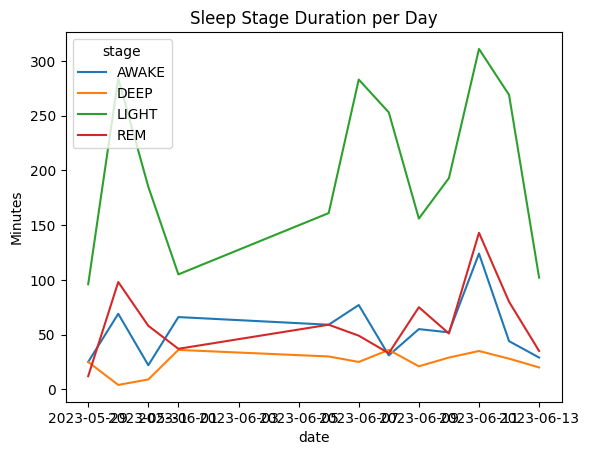

In [6]:

# convert start_time and end_time to datetime objects
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

# calculate duration for each sleep stage in minutes
df['duration'] = (df['end_time'] - df['start_time']).dt.total_seconds()/60

# create a column for the date
df['date'] = df['start_time'].dt.date

# group by date and stage, then sum durations
df_grouped = df.groupby(['date','stage'])['duration'].sum().reset_index()

# mapping of stages
stages = {40001:"AWAKE", 40002:"LIGHT",40003:"DEEP",40004:"REM"}
df_grouped['stage'] = df_grouped['stage'].map(stages)

# pivot df_grouped to have stages as columns
df_pivot = df_grouped.pivot(index='date', columns='stage', values='duration')

# plot
df_pivot.plot(kind='line', title='Sleep Stage Duration per Day')
plt.ylabel('Minutes')
plt.show()


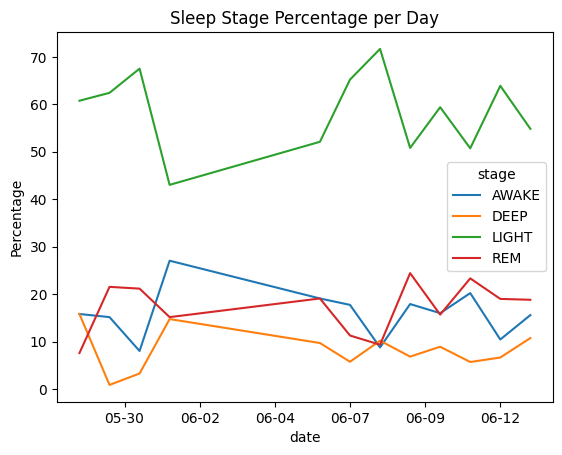

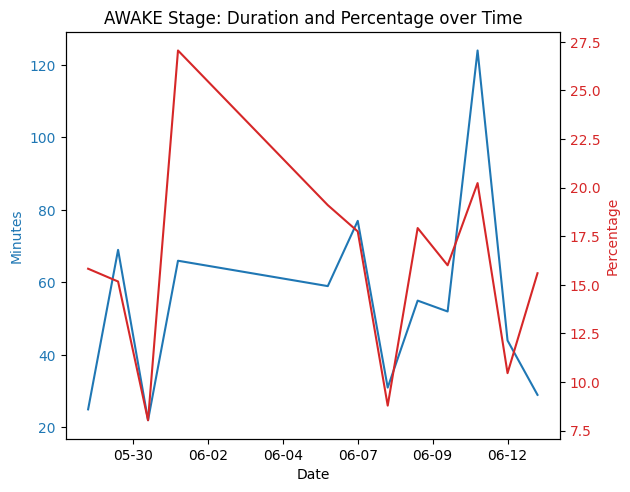

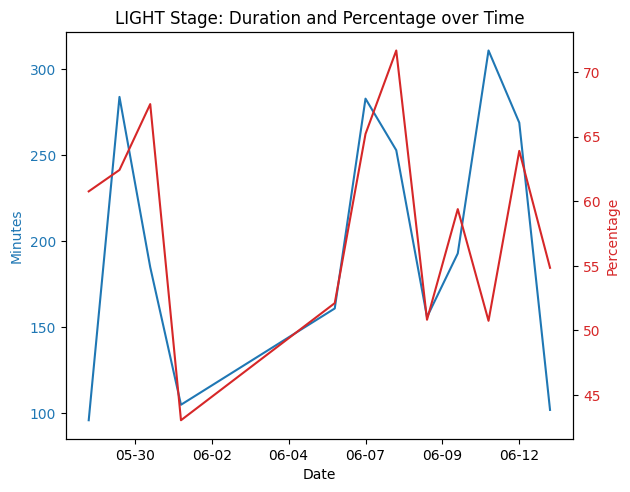

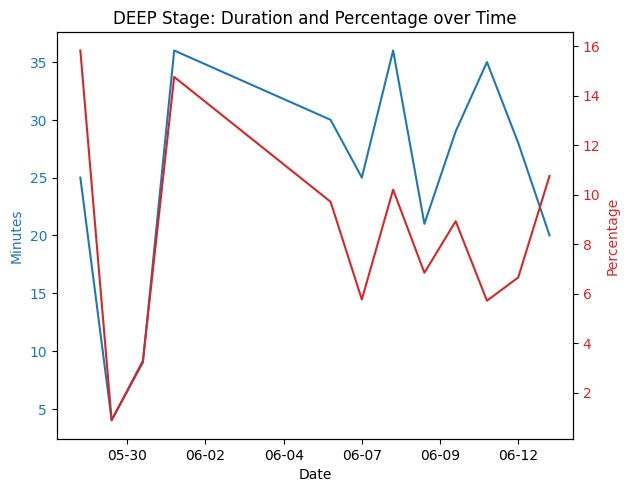

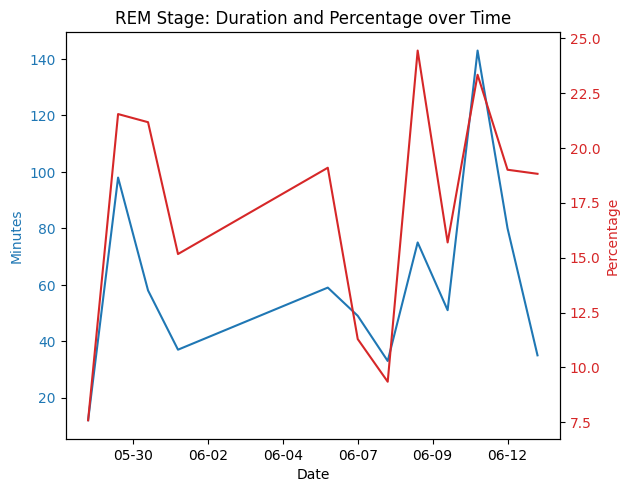

In [9]:
# calculate total sleep time for each day
total_sleep_per_day = df_grouped.groupby('date')['duration'].sum()

# calculate % duration for each stage
df_grouped['percentage'] = df_grouped.apply(lambda row: (row['duration'] / total_sleep_per_day[row['date']]) * 100, axis=1)

# pivot df_grouped to have stages as columns
df_pivot = df_grouped.pivot(index='date', columns='stage', values='percentage')

# plot
fig, ax = plt.subplots()
df_pivot.plot(kind='line', title='Sleep Stage Percentage per Day', ax=ax)
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=7)) # set the number of xticks
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))  # change date format to month-day
plt.ylabel('Percentage')
plt.show()

# plots for each stage with both duration and percentage
for stage in stages.values():
    df_stage = df_grouped[df_grouped['stage'] == stage]

    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Minutes', color=color)
    ax1.plot(df_stage['date'], df_stage['duration'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.xaxis.set_major_locator(ticker.MaxNLocator(nbins=7)) # set the number of xticks
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))  # change date format to month-day

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Percentage', color=color)
    ax2.plot(df_stage['date'], df_stage['percentage'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.xaxis.set_major_locator(ticker.MaxNLocator(nbins=7)) # set the number of xticks
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))  # change date format to month-day

    fig.tight_layout()
    plt.title(f'{stage} Stage: Duration and Percentage over Time')
    plt.show()


In [28]:
corr_matrix = df_pivot.corr()

print(corr_matrix)

stage     AWAKE      DEEP     LIGHT       REM
stage                                        
AWAKE  1.000000  0.384733 -0.884361  0.080019
DEEP   0.384733  1.000000 -0.361436 -0.615037
LIGHT -0.884361 -0.361436  1.000000 -0.385713
REM    0.080019 -0.615037 -0.385713  1.000000


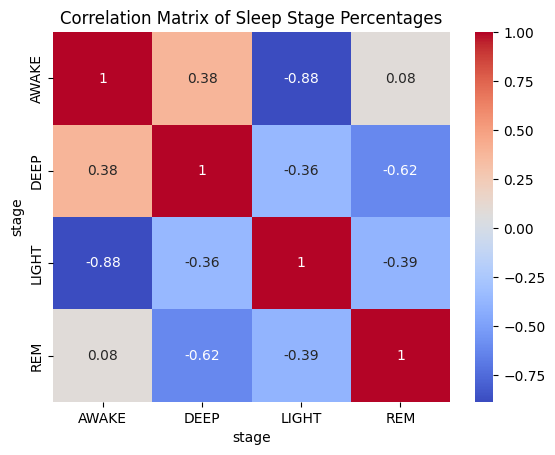

In [29]:
# visualize correlation matrix using a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Sleep Stage Percentages')
plt.show()